In [1]:
import os, sys, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
import matplotlib.patheffects as patheffects
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io import fits
from astropy.visualization import (AsinhStretch, LinearStretch, ImageNormalize)

sys.path.append('../frank_fit')
import diskdictionary as disk
from myutils import Jybeam_to_Jysr, Jysr_to_Tb, Jysr_to_Tb_err, Jysr_to_Tb_RJ, Jysr_to_Tb_RJ_err
from gofish import imagecube  
from scipy.interpolate import griddata

arcsec = 1/3600 * np.pi/180
deg = np.pi/180

In [2]:
def deproject_polar_plot(fitsfile, diskPA, distance):

    dcube_gofish = imagecube(fitsfile, FOV=7.)
    dcube_gofish_mJy_beam = dcube_gofish.data*1e3
    #Tb_gofish = (1e-23 * cube_gofish.data / beam_area) * c_**2 / (2 * k_ * freq**2)

    dmidplane_cart_coords = dcube_gofish._get_midplane_cart_coords(x0=disk.disk[target]['dx'],y0=disk.disk[target]['dy'],inc=disk.disk[target]['incl'], PA=diskPA)

    x_arr = np.linspace(3.5, -3.5, 1001)
    y_arr = np.linspace(-3.5, 3.5, 1001)
    x_meshgrid, y_meshgrid = np.meshgrid(x_arr, y_arr)

    dgriddata_deproj = griddata((-dmidplane_cart_coords[0].flatten(), -dmidplane_cart_coords[1].flatten()), dcube_gofish_mJy_beam.flatten(), (x_meshgrid, y_meshgrid), method='nearest')

    ##########################
    ### Polar plot
    ##########################

    # It seems to be an inefficient way to obtain a polar plot. In principle, I could simply plot 
    # pcolormesh(r, theta, Tb) 
    # and it should be fine. However, it is not. The result is very grainy.
    # After many tests, this seems to be the best pipeline. In particular, something that makes the final polar plot 
    # much better is to execute the second griddata using radiants instead of degrees 
    # (must be some numerical effect)

    R_meshgrid = np.hypot(x_meshgrid, y_meshgrid)
    phi_meshgrid = -np.arctan2(y_meshgrid, x_meshgrid)
    phi_meshgrid = phi_meshgrid + np.pi / 2 
    phi_meshgrid = (phi_meshgrid + np.pi) % (2 * np.pi) - np.pi

    R_arr_output = np.linspace(0, 4, 501)
    phi_arr_output = np.linspace(-np.pi, np.pi, 501)
    R_meshgrid_output, phi_meshgrid_output = np.meshgrid(R_arr_output, phi_arr_output)

    dgriddata_polar = griddata((R_meshgrid.flatten(), phi_meshgrid.flatten()), dgriddata_deproj.T.flatten(), (R_meshgrid_output, phi_meshgrid_output), method='nearest')
    
    R_finalgrid_au = R_meshgrid_output*distance
    phi_finalgrid_deg = phi_meshgrid_output*180/np.pi
    
    return dgriddata_polar, R_finalgrid_au, phi_finalgrid_deg

In [ ]:
##### MODIFY HERE #####

target = 'AA_Tau'
target_label = disk.disk[target]['label']

robust = -0.5
distance_pc = disk.disk[target]['distance']
RMS_data = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[5]

axlabel_size = 17
axlabel_pad = 4
ticklabel_size = 14
txt_size = 15
name_size = 17

ticklabel_size = 14
majtick_lenght = 5
majtick_width = 2.3
mintick_length = 3.5
mintick_width = 1.2

index_ticks = 0.5
res_vmin, res_vmax = -9, 9
Rindex_ticks = 50
Rmax = 200
setticks = [0,1,2]

# load data
data_fits = f'../frank_fit/CLEAN/robust{robust}/{target}_data_robust{robust}.fits'
dhdu = fits.open(data_fits)
dimg, hd = np.squeeze(dhdu[0].data), dhdu[0].header
freq = hd['CRVAL3']

# load residual image
resid_fits = f'../frank_fit/CLEAN/robust{robust}/{target}_resid_robust{robust}.fits'
rhdu = fits.open(resid_fits)
rimg = np.squeeze(rhdu[0].data)

# create polar plots
dgriddata_polar, R_finalgrid_au, phi_finalgrid_deg = deproject_polar_plot(data_fits, disk.disk[target]['PA'], distance_pc)
rgriddata_polar, R_finalgrid_au, phi_finalgrid_deg = deproject_polar_plot(resid_fits, disk.disk[target]['PA'], distance_pc)

bmaj, bmin, bPA = 3600 * hd['BMAJ'], 3600 * hd['BMIN'], hd['BPA']
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

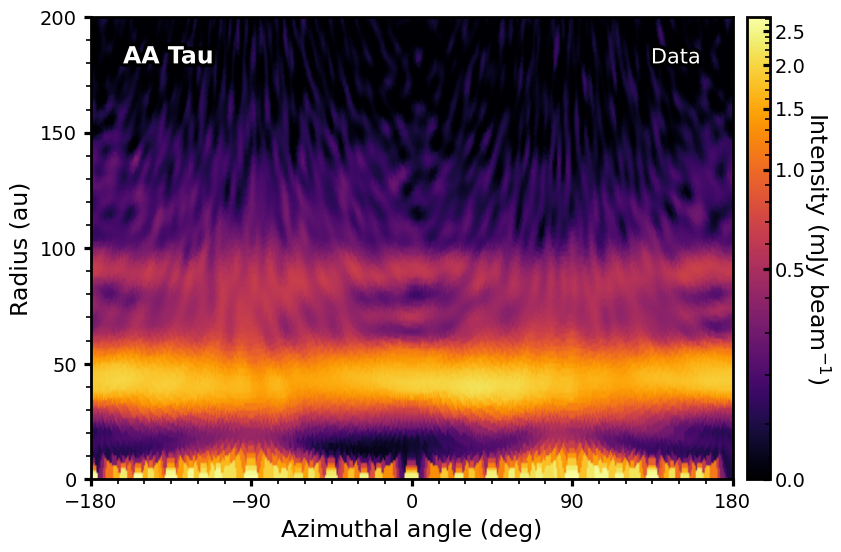

In [4]:
###############################
####### Polar Data ############
###############################

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

# intensity limits, and stretch
norm = ImageNormalize(vmin=0, vmax=np.nan_to_num(dgriddata_polar).max(), stretch=AsinhStretch())

im = ax.pcolormesh(phi_finalgrid_deg, R_finalgrid_au, dgriddata_polar,  cmap='inferno',  norm=norm, shading='gouraud', rasterized=True)

cbar = fig.colorbar(im, ax=ax, pad=0.02,fraction=0.06)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar.set_label('Intensity (mJy $\mathrm{beam}^{-1}$)', rotation=270, labelpad=axlabel_pad+15, fontsize = axlabel_size)
cbar.ax.minorticks_on()

# Write source name
ax.text(0.05, 0.9, s=target_label,
        transform=ax.transAxes, color='w', fontsize=name_size, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="k")])

ax.text(0.95, 0.9, "Data",
        transform=ax.transAxes, color='w', fontsize=txt_size, 
        path_effects=[patheffects.withStroke(linewidth=5, foreground="k")], ha='right')

ax.set_xlim(-180, 180)
ax.set_ylim(0,Rmax)

xindex_ticks = 90
ax.xaxis.set_major_locator(MultipleLocator(xindex_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(xindex_ticks/6))

ax.yaxis.set_major_locator(MultipleLocator(Rindex_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(Rindex_ticks/5))

ax.tick_params(which='major',axis='both', labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='out',color='k')
ax.tick_params(which='minor',axis='both', labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='out',color='k')
ax.set_xlabel('Azimuthal angle (deg)', fontsize = axlabel_size, labelpad=5)
ax.set_ylabel('Radius (au)', fontsize = axlabel_size, labelpad=5)

for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(2)

In [5]:
# residuals color map
c2 = plt.cm.Reds(np.linspace(0, 1, 32))
c1 = plt.cm.Blues_r(np.linspace(0, 1, 32))
c1 = np.vstack([c1, np.ones((10, 4))])
colors = np.vstack((c1, c2))
mymap = mcolors.LinearSegmentedColormap.from_list('eddymap', colors)
separations = 20   # discrete colorbar
discrete_colors = plt.get_cmap(mymap)(np.linspace(0,1,separations))
discrete_cmap = mcolors.ListedColormap(discrete_colors) 

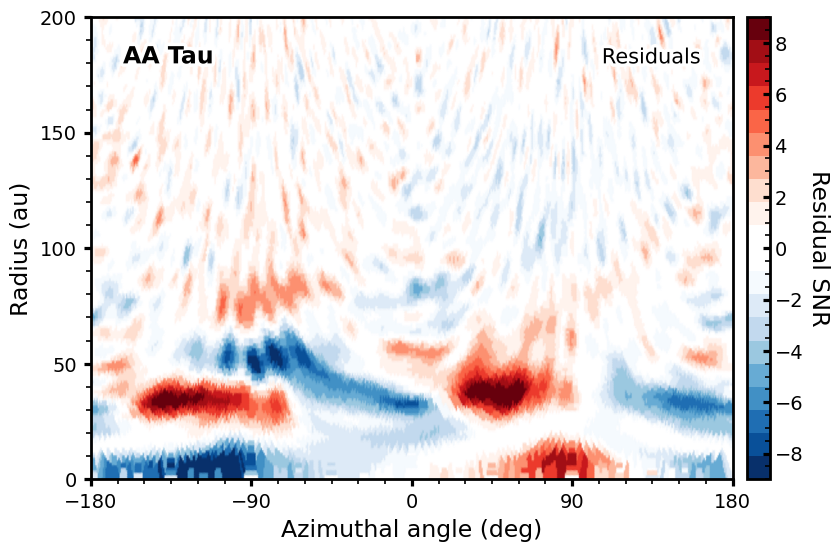

In [6]:
###################################
####### Polar Residual ############
###################################

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

# intensity limits, and stretch
norm = ImageNormalize(vmin=res_vmin, vmax=res_vmax, stretch=LinearStretch())

im = ax.pcolormesh(phi_finalgrid_deg, R_finalgrid_au, rgriddata_polar/RMS_data,  cmap=discrete_cmap,  norm=norm, shading='gouraud', rasterized=True)

cbar = fig.colorbar(im, ax=ax, pad=0.02,fraction=0.06)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(which='major', labelsize=ticklabel_size,width=majtick_width, length=majtick_lenght,direction='in')
cbar.ax.tick_params(which='minor', labelsize=ticklabel_size,width=mintick_width, length=mintick_length,direction='in')
cbar.set_label('Residual SNR', rotation=270, labelpad=axlabel_pad+15, fontsize = axlabel_size)
cbar.ax.minorticks_on()

# Write source name
ax.text(0.05, 0.9, s=target_label,
        transform=ax.transAxes, color='k', fontsize=name_size, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

ax.text(0.95, 0.9, "Residuals",
        transform=ax.transAxes, color='k', fontsize=txt_size, 
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")], ha='right')

ax.set_xlim(-180, 180)
ax.set_ylim(0,Rmax)

xindex_ticks = 90
ax.xaxis.set_major_locator(MultipleLocator(xindex_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(xindex_ticks/6))

ax.yaxis.set_major_locator(MultipleLocator(Rindex_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(Rindex_ticks/5))

ax.tick_params(which='major',axis='both', labelsize=ticklabel_size, pad=5,width=majtick_width, length=majtick_lenght,direction='out',color='k')
ax.tick_params(which='minor',axis='both', labelsize=ticklabel_size, pad=5,width=mintick_width, length=mintick_length,direction='out',color='k')
ax.set_xlabel('Azimuthal angle (deg)', fontsize = axlabel_size, labelpad=5)
ax.set_ylabel('Radius (au)', fontsize = axlabel_size, labelpad=5)

for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(2)